In [5]:
!pip install emoji

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=9a39d645d2514dce9e0cbf928571a011a0d78dc7d64442e5f6cabf04e7525702
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import string #preprocess
import csv   #reading files
import emoji #to convert emojis to words using demojize function
import keras

#preprocess function
import string
def preprocess(list_of_tweets):
  normalised_corpus =[]
  for tweet in list_of_tweets:
    words =[]
    for word in tweet:
      word = word.lower()
      word = word.strip(string.punctuation)
      word = word.strip(string.digits)
      if word not in string.punctuation and word != "url": 
        words.append(word)
    normalised_corpus.append(words)
  return normalised_corpus  

In [0]:
#getting train data
from keras.preprocessing.text import Tokenizer
raw_data =[] #stores all contents of tsv file as list of list [[id,tweet,A,B,C],[...]]
with open("olid-training-v1.0.tsv",encoding='UTF-8') as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        raw_data.append(row)

raw_data.remove(raw_data[0]) #remove first list item since it contains headers

#converts emoji to words and converts each tweet from string to list of words
raw_tweets = []
for tweet in raw_data:
  tweet[1] = emoji.demojize(tweet[1])
  temp = tweet[1].split()
  raw_tweets.append(temp)

 #convert to lower, remove punctuation and digits and words like 'user' and 'url' 
clean_tweets = preprocess(raw_tweets)

num_words=20000  #optional UNIQUE WORDS around 22156
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_tweets)

word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
sents_as_ids = tokenizer.texts_to_sequences(clean_tweets)


from keras.preprocessing.sequence import pad_sequences
MAXIMUM_LENGTH = 30 #checking
processed_train_data = pad_sequences(sents_as_ids,MAXIMUM_LENGTH,truncating='post')


In [0]:
# GETTING ALL THE LABELS
train_labels_A = [tweet[2] for tweet in raw_data ]
train_labels_B = [tweet[3] for tweet in raw_data ]
train_labels_C = [tweet[4] for tweet in raw_data ]
combined_train_labels = []  #combining all labels 

#print(train_labels_A)
preprocessed_label_A = []
for labelA in train_labels_A:
  if labelA =="OFF":
    preprocessed_label_A.append(1)
  else:
    preprocessed_label_A.append(0)

for i in range(len(train_labels_A)):
  if train_labels_A[i] =="OFF":
    if train_labels_C[i] !="NULL":
      temp = train_labels_A[i] + train_labels_B[i] + train_labels_C[i] 
    else:
      temp = train_labels_A[i] + train_labels_B[i]
  else:
    temp = train_labels_A[i]
  combined_train_labels.append(temp)

#sanity check
#print("first 10 combined train labels: ",combined_train_labels[:10])

unique_labels = {}
count =0
for label in combined_train_labels:
  if label not in unique_labels.keys():
    unique_labels[label] = count
    count+=1

#print(unique_labels)

labels_to_ids = []

for label in combined_train_labels:
  labels_to_ids.append(unique_labels[label])


In [9]:
#CONVERTS ALL LABELS TO ONE HOT ENCODING [1,0,0,0,0] for all 5 classes
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(labels_to_ids)
encoded_Y = encoder.transform(labels_to_ids)
# convert integers to dummy variables (i.e. one hot encoded)
processed_train_labels = np_utils.to_categorical(encoded_Y)
print("one hot encoded train labels \n ",processed_train_labels[:10])

one hot encoded train labels 
  [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [0]:
VOCAB_SIZE = len(word2idx)+1  # 0 saved for padding so we add 1
EMBD_SIZE =100
output = len(unique_labels.keys())
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(VOCAB_SIZE,EMBD_SIZE))
model2.add(keras.layers.Dropout(rate=0.5))
model2.add(keras.layers.LSTM(units=100,activation='tanh'))
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(output,activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [80]:
partial_train_dataABC = processed_train_data[:10240]
partial_val_dataABC = processed_train_data[10240:]

partial_train_labels_ABC = processed_train_labels[:10240]
partial_val_labels_ABC = processed_train_labels[10240:]

history = model2.fit(partial_train_dataABC,partial_train_labels_ABC,batch_size=100,
            epochs=3,validation_data=(partial_val_dataABC,partial_val_labels_ABC),verbose=1)


Train on 10240 samples, validate on 3000 samples
Epoch 1/3
10240/10240 [==============================] - 15s 1ms/step - loss: 1.0745 - acc: 0.6562 - val_loss: 0.9818 - val_acc: 0.6683
Epoch 2/3
10240/10240 [==============================] - 11s 1ms/step - loss: 0.9072 - acc: 0.6826 - val_loss: 0.8874 - val_acc: 0.6873
Epoch 3/3
10240/10240 [==============================] - 11s 1ms/step - loss: 0.7037 - acc: 0.7530 - val_loss: 0.8959 - val_acc: 0.6983


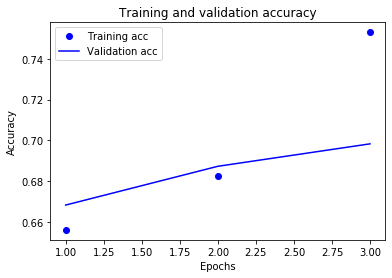

In [81]:
# PLOT of train and validation accuracy
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#GET RAW TEST DATA AND CONVERT TO DICTIONERY WITH KEY (ID AS INT) AND VALUE =TWEET 
raw_test_data =[]

with open("testset-levela.tsv",encoding='UTF-8') as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        raw_test_data.append(row)
        
raw_test_data.remove(raw_test_data[0]) #remove first element since it contains headers       

raw_test_data_dict =dict(raw_test_data)
raw_test_data_dict = {int(k) : v for k,v in raw_test_data_dict.items()}


In [0]:
#processing the test labels
#converting labels to key value pairs
def get_test_labels(path):
  raw_test_labels =[]
  with open(path) as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        raw_test_labels.append(row)
  temp_test_labels = [labels[0].split(',') for labels in raw_test_labels]
  return temp_test_labels

#get labels with IDs
test_labels_A = get_test_labels('labels-levela.csv')
test_labels_B = get_test_labels('labels-levelb.csv')
test_labels_C = get_test_labels('labels-levelc.csv')

dict1 =dict(test_labels_A)
dict1 = {int(k) : v for k,v in dict1.items()}
dict2 =dict(test_labels_B)
dict2 = {int(k) : v for k,v in dict2.items()}
dict3 =dict(test_labels_C)
dict3 = {int(k) : v for k,v in dict3.items()}


In [84]:
from keras.preprocessing.sequence import pad_sequences
#this list will store tweet and corrosponding concatenated labels so its a list of list containing tweet and label
combined_test_data = [] 
for key in raw_test_data_dict.keys():
    raw_test_data_dict[key] = emoji.demojize(raw_test_data_dict[key]) #demojize
    l1 = raw_test_data_dict[key].split()
    if key in dict3.keys():
        label_temp = dict1[key]+dict2[key]+dict3[key]
        tweet = [l1,label_temp]
    elif key in dict2.keys():     
        label_temp = dict1[key]+dict2[key]
        tweet = [l1,label_temp]
    elif key in dict1.keys():          
        tweet = [l1,dict1[key]]
    combined_test_data.append(tweet)

raw_test_tweets =[]
raw_test_labels =[]
for list1 in combined_test_data:
    raw_test_tweets.append(list1[0])
    raw_test_labels.append(list1[1])

clean_test_tweets = preprocess(raw_test_tweets)
test_sents_as_ids = tokenizer.texts_to_sequences(clean_test_tweets)



MAXIMUM_LENGTH = 30 #checking
processed_test_data = pad_sequences(test_sents_as_ids,MAXIMUM_LENGTH,truncating='post')


test_labels_to_ids = []

for label in raw_test_labels:
  test_labels_to_ids.append(unique_labels[label])


#CONVERT TEST LABELS TO ONE HOT LABEL ENCODING
encoded_testY = encoder.transform(test_labels_to_ids)
processed_test_labels = np_utils.to_categorical(encoded_testY)

#sanity check
print(test_labels_to_ids[:10])
print("one hot encoded test labels \n ",processed_test_labels[:10])


[3, 2, 2, 2, 4, 1, 2, 3, 2, 2]
one hot encoded test labels 
  [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [85]:
model2.evaluate(processed_test_data,processed_test_labels,batch_size=128)

860/860 [==============================] - 0s 186us/step


[0.8264578420062397, 0.7279069764669551]